In [6]:
%matplotlib inline
import pandas as pd
import sys
import string
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfTransformer
import sklearn.datasets
import sklearn.metrics
import sklearn.svm
import sklearn.naive_bayes
import sklearn.neighbors
import os
import nltk
import re
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
from sklearn.datasets import load_files
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import TransformerMixin
import math
import _pickle as cPickle
from sklearn.externals import joblib

Using Naive Baye's
Print here the mean value
Print metric report
0.778617302607
               precision    recall  f1-score   support

Not an insult       0.77      1.00      0.87      1954
       Insult       0.93      0.17      0.28       693

  avg / total       0.81      0.78      0.72      2647



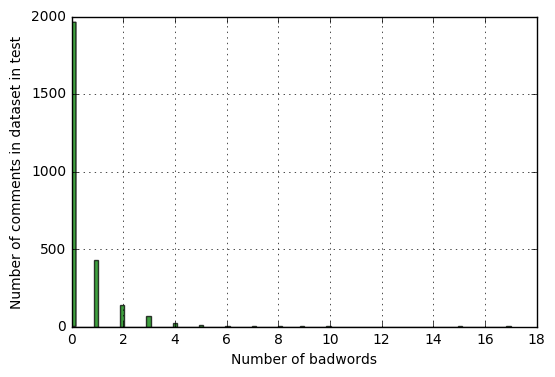

In [7]:
bw_list = []

class BadWordTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        X = X.astype('str').map(lambda x: x.split() if (x!='nan') else '')

        return pd.DataFrame(X.map(lambda x: len(list(filter((lambda y: y in bw_list), x) ))))


    def fit(self, X, y=None, **fit_params):
        return self

with open(r"my_classifier.pkl", "rb") as input_file:
    text_clf = cPickle.load(input_file)

bw = open('bad_words.txt', 'r')
inp_text = bw.read()  # reading file generated from puzzleenerator.py
inp_text = re.split('\n|,', inp_text)
bw_list= [word.replace( u"\xa0",u"") for word in inp_text]
target_names = ['Not an insult', 'Insult']

# Training
dataframe_dataset = pd.read_csv("./Train_clean.csv", na_values='unknown', encoding="utf-8")
bw = open('bad_words.txt', 'r')
inp_text = bw.read()  # raeding file generated from puzzleenerator.py
inp_text = re.split('\n|,', inp_text)

bw_list= [word.replace( u"\xa0",u"") for word in inp_text]


dataframe_dataset["joined replaced stemmed"].fillna(" ", inplace=True)
dataframe_dataset["bad words"] = dataframe_dataset["joined replaced stemmed"]. \
    astype('str').map(lambda x: x.split() if (x!='nan') else '')

dataframe_dataset["bad words"] = dataframe_dataset["bad words"]. \
    map(lambda x: len(list(filter((lambda y: y in bw_list), x) )))

print("Using Naive Baye's")
'''
text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(2, 2))),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                     ])
'''
text_clf = Pipeline([
    ('features', FeatureUnion([
        ('ngram_tf_idf', Pipeline([
            ('counts', CountVectorizer(ngram_range=(2, 2))),
            ('tf_idf', TfidfTransformer())
            ])),
        ('badwords', BadWordTransformer())
        ])),
    ('classifier', MultinomialNB())
    ])

text_clf = text_clf.fit(dataframe_dataset["joined replaced stemmed"],dataframe_dataset["Insult"])

print("Print here the mean value")
print("Print metric report")

# Testing
dataframe_dataset_test = pd.read_csv("./Test_clean.csv", na_values='unknown', encoding="utf-8")
dataframe_dataset_test["joined replaced stemmed"].fillna(" ", inplace=True)

dataframe_dataset_test["bad words"] = dataframe_dataset_test["joined replaced stemmed"]. \
    astype('str').map(lambda x: x.split() if (x!='nan') else '')

dataframe_dataset_test["bad words"] = dataframe_dataset_test["bad words"]. \
    map(lambda x: len(list(filter((lambda y: y in bw_list), x) )))

predicted = text_clf.predict(dataframe_dataset_test["joined replaced stemmed"])
print(np.mean(predicted == dataframe_dataset_test["Insult"]))
print(metrics.classification_report(dataframe_dataset_test["Insult"], predicted, target_names=target_names))


fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.hist(dataframe_dataset_test["bad words"], 100, facecolor='green', alpha=0.75)
ax1.set_xlabel('Number of badwords')
ax1.set_ylabel('Number of comments in dataset in test')
# ax1.axvline(normed_mil.mean(), color='b', linestyle='dashed', linewidth=2)
ax1.grid(True)
plt.savefig('testplot-hist1.png')



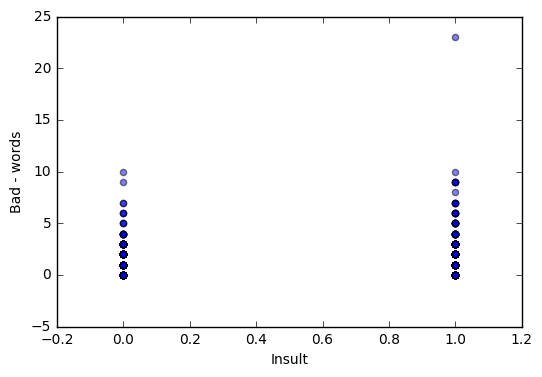

In [9]:

# colors = np.random.rand(len(country_data))

x = np.array((dataframe_dataset["Insult"]))

y = np.array(dataframe_dataset["bad words"])
# area = np.pi * (np.log10(normed_pop*100)*2)**3  # 0 to 15 point radiuses

plt.scatter(x, y, alpha=0.5)

plt.xlabel("Insult")
plt.ylabel("Bad - words")
plt.savefig('trainplot-scatter.png')
plt.show()


[1 1 1 ..., 1 1 1]


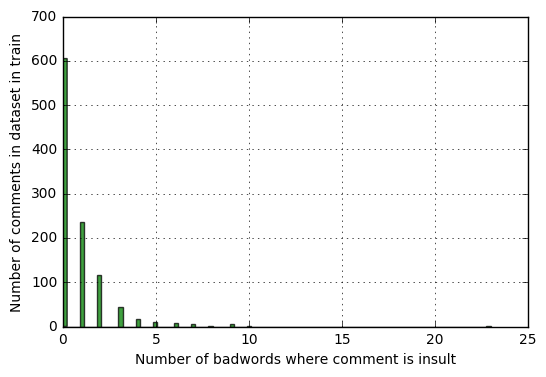

In [11]:

fig1 = plt.figure()
x = np.array((dataframe_dataset.loc[dataframe_dataset["Insult"] == 1])["Insult"])
print (x)
ax1 = fig1.add_subplot(111)
ax1.hist((dataframe_dataset.loc[dataframe_dataset["Insult"] == 1])["bad words"], 100, facecolor='green', alpha=0.75)
ax1.set_xlabel('Number of badwords where comment is insult')
ax1.set_ylabel('Number of comments in dataset in train')
# ax1.axvline(normed_mil.mean(), color='b', linestyle='dashed', linewidth=2)
ax1.grid(True)
plt.savefig('trainplot-hist1.png')
plt.show()

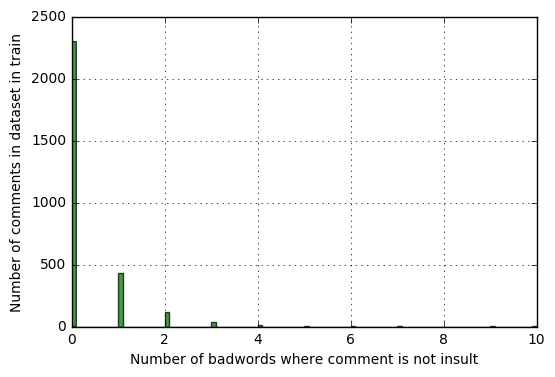

In [12]:

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.hist((dataframe_dataset.loc[dataframe_dataset["Insult"] == 0])["bad words"], 100, facecolor='green', alpha=0.75)
ax1.set_xlabel('Number of badwords where comment is not insult')
ax1.set_ylabel('Number of comments in dataset in train')
# ax1.axvline(normed_mil.mean(), color='b', linestyle='dashed', linewidth=2)
ax1.grid(True)
plt.savefig('trainplot-hist2.png')

plt.show()


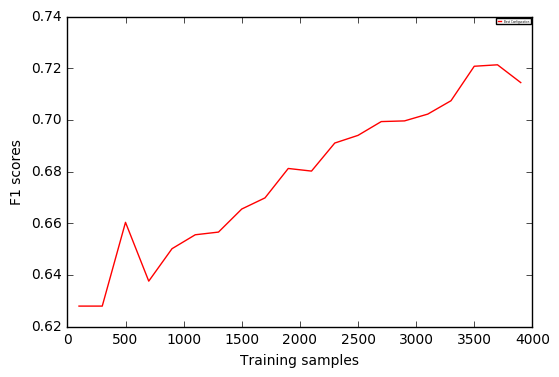

In [16]:

SVC_values = []
for n in range(100, len(dataframe_dataset), 200):
    text_clf = text_clf.fit(dataframe_dataset["joined replaced stemmed"].head(n),dataframe_dataset["Insult"].head(n))
    predicted = text_clf.predict(dataframe_dataset_test["joined replaced stemmed"])
    SVC_values.append(metrics.f1_score(dataframe_dataset_test["Insult"], predicted, average='weighted'))

xaxis = [n for n in range(100, len(dataframe_dataset),200)]
plt.plot(xaxis,SVC_values,'r-', label='Best Configuration')
plt.xlabel('Training samples')
plt.ylabel('F1 scores')
plt.savefig('trainplot-learning.png')
plt.legend(prop={'size':4})
plt.show()